<br><br>

# Exercício: Sistemas de Recomendação

<br>

__Introdução: o objetivo deste exercício é discutirmos uma metodologia de avaliação de filtros colaborativos.__

<br>

Para isso, utilize a função getData() para carregar os dados: 

    - teremos avaliações que 367 usuários fizeram a respeito de 80 filmes. As notas variam entre 1, 2, 3, 4, e 5. 
    
    - os valores NaN representam filmes que ainda não foram avaliados pelos usuários.

Como __modelo__ para as recomendações, usaremos a __fatoração matricial.__ Use a classe MatrixFactorization() construída ao longo do módulo.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def getData():
    r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
    ratings = pd.read_csv('u.data', sep='\t', names=r_cols,
                          encoding='latin-1')
    m_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
    movies = pd.read_csv('u.item', sep='|', names=m_cols, usecols=range(5),
                         encoding='latin-1')
    movie_ratings = pd.merge(movies, ratings)
    temp = movie_ratings[['movie_id', 'user_id', 'rating']].copy()
    temp = temp.pivot_table(columns='movie_id', index='user_id', values='rating').copy()
    temp.index = ['User_'+str(int(i)) for i in temp.index]
    temp.columns = ['Filme_'+str(int(i)) for i in temp.columns]
    qtd_cols = 80
    R = temp.iloc[:, :qtd_cols]
    l=[]
    for i in range(1, R.shape[0]+1):
        if R.iloc[i-1, ].isnull().sum() >= (qtd_cols - 10):
            l.append(i)
    R = R.drop(["User_"+str(r) for r in l])
    R.index = ['User_'+str(int(i)) for i in range(R.shape[0])]
    return R

In [4]:
import time

class MatrixFactorization():
    
    def __init__(self, dataframe, K, steps, alpha, beta):
        self.df = dataframe
        self.K = K
        self.steps = steps
        self.alpha = alpha
        self.beta = beta
        
    def fit(self):
        t0 = time.time()
        
        R = self.df.values
        N, M = R.shape
        
        #inicio aleatorio
        P = np.random.rand(N,self.K)
        Q = np.random.rand(self.K,M)
        
        lista_erro_step = []
        
        #loop
        for step in range(self.steps):
            
            mse_total_step = 0
            #varrendo todas as entradas da matriz R
            for i in range(len(R)):
                for j in range(len(R[i])):
                    #validando se o valor associado está preenchido
                    if R[i][j] > 0:

                        #calculando o erro:
                        eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                        mse_total_step += (eij)**2
                        #alterando os valores
                        for k in range(self.K):
                            P[i][k] = P[i][k] + self.alpha * ( 2 * eij * Q[k][j] - self.beta * P[i][k])
                            Q[k][j] = Q[k][j] + self.alpha * ( 2 * eij * P[i][k] - self.beta * Q[k][j])
                            
            lista_erro_step.append(mse_total_step)
            
        self.P = P
        self.Q = Q
        self.lista_erro_step = lista_erro_step
        t1 = time.time()
        print("Fatoração concluída. Tempo aproximado:", int((t1-t0)/60)+1, 'minuto(s).')
        
    def predict(self):
        return self.P.dot(self.Q)
    
    def mse(self):
        return self.lista_erro_step
    
    def print_MSE_steps(self):
        plt.figure(figsize=[15,6])
        plt.title("Custo total por Step", fontsize = 16, fontweight = 'bold')
        plt.xlabel("Step", fontsize = 14, fontweight = 'bold')
        plt.ylabel("Erro", fontsize = 14, fontweight = 'bold')
        plt.plot(range(1, 1+self.steps), self.lista_erro_step, c = 'blue', lw = 2)
        plt.grid()
        plt.show()

<br><br>

Tradicionalmente, para avaliarmos a performance de algoritmos de machine learning, fazemos a divisão dos dados em treino/teste; os dados de teste são utilizados no modelo final, apenas para validar que o mesmo não está sofrendo overfitting e está generalizando bem.

No contexto dos filtros colaborativos, tal divisão dos dados não fará sentido: os métodos discutidos (de filtragem colaborativa) usam as informações de interação dos usuários com itens para "preencher os valores faltantes" da matriz de interação. Esse preenchimento é justamente a recomendação!

<br>

No entanto, podemos aplicar uma __metodologia que "simula" dados de treino/teste.__ 

Essencialmente, essa metodologia consiste de criar uma base de treino em que retiramos algumas interações dos usuários. Dessa forma, os modelos irão aprender os padrões dos dados sem terem acesso a toda informação.

Nos dados de teste, usaremos essas interações retiradas em treino para avaliar os resultados.

<br>

__Considere o exemplo:__

Vamos carregar, novamente, o dataset que usamos ao longo do módulo:

In [5]:
def getDF():
    dic__ = {"User_1":[np.nan, np.nan, np.nan, 1, 7, 2, 3, 8],
         "User_2":[9,10,2,2,6,5,3,8],
         "User_3":[4, 7, 9, 6,6,10,10,2],
         "User_4":[np.nan, 7, 9, 5, 5, 10, 9, 1],
         "User_5":[7.0,6.0,3.0,8.0,3,4.0,3.0, 2],
         "User_6":[np.nan, np.nan, 9, 9,6,8,9,np.nan],
         "User_7":[3,5,4,4,3,3,9,np.nan],
         "User_8":[10,10,10,10,2,2,2,2],
         "User_9":[9,9,np.nan,8,3,3,1,np.nan],
         "User_10":[9,8,10,9,3,4,2,1],
         "User_11":[4,4,3,3,9,9,8,10],
         "User_12":[2,2,4,1,8,10,10,9],
         "User_13":[1,4,1,3,7,10,7,8],
         "User_14":[3,3,2,1,1,10, np.nan,10],
         "User_15":[9,9,8,10,4,2,np.nan,1]
        }
    df = pd.DataFrame(dic__).T
    df.columns = ['Filme_'+str(int(i+1)) for i in range(8)]
    return df

In [6]:
df = getDF()
df

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8
User_1,NaN,NaN,NaN,1.0,7.0,2.0,3.0,8.0
User_2,9.0,10.0,2.0,2.0,6.0,5.0,3.0,8.0
User_3,4.0,7.0,9.0,6.0,6.0,10.0,10.0,2.0
User_4,NaN,7.0,9.0,5.0,5.0,10.0,9.0,1.0
User_5,7.0,6.0,3.0,8.0,3.0,4.0,3.0,2.0
User_6,NaN,NaN,9.0,9.0,6.0,8.0,9.0,NaN
User_7,3.0,5.0,4.0,4.0,3.0,3.0,9.0,NaN
User_8,10.0,10.0,10.0,10.0,2.0,2.0,2.0,2.0
User_9,9.0,9.0,NaN,8.0,3.0,3.0,1.0,NaN
User_10,9.0,8.0,10.0,9.0,3.0,4.0,2.0,1.0


<br>

Abaixo, criamos o array "ratings", que consiste de nossa matriz de interação usuário/item. No entanto, fizemos um completamento com "0" nos dados faltantes. Dessa forma, o rating = 0 significa que o usuário não avaliou o filme em questão.

<br>

In [7]:
ratings = df.fillna(0).values
ratings

array([[ 0.,  0.,  0.,  1.,  7.,  2.,  3.,  8.],
       [ 9., 10.,  2.,  2.,  6.,  5.,  3.,  8.],
       [ 4.,  7.,  9.,  6.,  6., 10., 10.,  2.],
       [ 0.,  7.,  9.,  5.,  5., 10.,  9.,  1.],
       [ 7.,  6.,  3.,  8.,  3.,  4.,  3.,  2.],
       [ 0.,  0.,  9.,  9.,  6.,  8.,  9.,  0.],
       [ 3.,  5.,  4.,  4.,  3.,  3.,  9.,  0.],
       [10., 10., 10., 10.,  2.,  2.,  2.,  2.],
       [ 9.,  9.,  0.,  8.,  3.,  3.,  1.,  0.],
       [ 9.,  8., 10.,  9.,  3.,  4.,  2.,  1.],
       [ 4.,  4.,  3.,  3.,  9.,  9.,  8., 10.],
       [ 2.,  2.,  4.,  1.,  8., 10., 10.,  9.],
       [ 1.,  4.,  1.,  3.,  7., 10.,  7.,  8.],
       [ 3.,  3.,  2.,  1.,  1., 10.,  0., 10.],
       [ 9.,  9.,  8., 10.,  4.,  2.,  0.,  1.]])

<br>

Na sequência, apresentamos a função que faz a divisão dos dados em treino e teste.

<br>

In [8]:
def train_test_split(ratings, qtd):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=qtd, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    return train, test

In [9]:
train, test = train_test_split(ratings, qtd = 2)

<br>

__Vamos comparar os dados de treino e teste com os dados originais:__
    
<br>

In [10]:
#matriz de interação - original;

ratings

array([[ 0.,  0.,  0.,  1.,  7.,  2.,  3.,  8.],
       [ 9., 10.,  2.,  2.,  6.,  5.,  3.,  8.],
       [ 4.,  7.,  9.,  6.,  6., 10., 10.,  2.],
       [ 0.,  7.,  9.,  5.,  5., 10.,  9.,  1.],
       [ 7.,  6.,  3.,  8.,  3.,  4.,  3.,  2.],
       [ 0.,  0.,  9.,  9.,  6.,  8.,  9.,  0.],
       [ 3.,  5.,  4.,  4.,  3.,  3.,  9.,  0.],
       [10., 10., 10., 10.,  2.,  2.,  2.,  2.],
       [ 9.,  9.,  0.,  8.,  3.,  3.,  1.,  0.],
       [ 9.,  8., 10.,  9.,  3.,  4.,  2.,  1.],
       [ 4.,  4.,  3.,  3.,  9.,  9.,  8., 10.],
       [ 2.,  2.,  4.,  1.,  8., 10., 10.,  9.],
       [ 1.,  4.,  1.,  3.,  7., 10.,  7.,  8.],
       [ 3.,  3.,  2.,  1.,  1., 10.,  0., 10.],
       [ 9.,  9.,  8., 10.,  4.,  2.,  0.,  1.]])

In [11]:
#dados de treino;
#observe que, para cada usuário (ou seja, para cada linha) 3 notas foram retiradas!! 
#ou seja, foram substituida por 0.

train

array([[ 0.,  0.,  0.,  1.,  0.,  2.,  3.,  0.],
       [ 0., 10.,  2.,  2.,  0.,  5.,  3.,  8.],
       [ 4.,  7.,  0.,  6.,  6., 10., 10.,  0.],
       [ 0.,  7.,  9.,  5.,  0., 10.,  9.,  0.],
       [ 7.,  6.,  0.,  8.,  3.,  0.,  3.,  2.],
       [ 0.,  0.,  0.,  9.,  0.,  8.,  9.,  0.],
       [ 0.,  5.,  4.,  4.,  3.,  3.,  0.,  0.],
       [ 0., 10., 10., 10.,  2.,  2.,  0.,  2.],
       [ 0.,  9.,  0.,  8.,  0.,  3.,  1.,  0.],
       [ 0.,  8., 10.,  0.,  3.,  4.,  2.,  1.],
       [ 4.,  0.,  3.,  3.,  0.,  9.,  8., 10.],
       [ 2.,  2.,  4.,  0.,  8., 10., 10.,  0.],
       [ 0.,  4.,  1.,  3.,  7.,  0.,  7.,  8.],
       [ 3.,  3.,  2.,  1.,  0., 10.,  0.,  0.],
       [ 0.,  9.,  0., 10.,  4.,  2.,  0.,  1.]])

In [12]:
#dados de teste;
#observe que exatamente as notas que foram retiradas de treino são colocadas nessa matriz de teste!!

test

array([[ 0.,  0.,  0.,  0.,  7.,  0.,  0.,  8.],
       [ 9.,  0.,  0.,  0.,  6.,  0.,  0.,  0.],
       [ 0.,  0.,  9.,  0.,  0.,  0.,  0.,  2.],
       [ 0.,  0.,  0.,  0.,  5.,  0.,  0.,  1.],
       [ 0.,  0.,  3.,  0.,  0.,  4.,  0.,  0.],
       [ 0.,  0.,  9.,  0.,  6.,  0.,  0.,  0.],
       [ 3.,  0.,  0.,  0.,  0.,  0.,  9.,  0.],
       [10.,  0.,  0.,  0.,  0.,  0.,  2.,  0.],
       [ 9.,  0.,  0.,  0.,  3.,  0.,  0.,  0.],
       [ 9.,  0.,  0.,  9.,  0.,  0.,  0.,  0.],
       [ 0.,  4.,  0.,  0.,  9.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  9.],
       [ 1.,  0.,  0.,  0.,  0., 10.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0., 10.],
       [ 9.,  0.,  8.,  0.,  0.,  0.,  0.,  0.]])

<br>

Na prática, usaremos os dados de treino para treinar e escolher os modelos.

Neste caso, podemos, inclusive, fazer a divisão em treino/validação/teste:
    


In [13]:
train, val = train_test_split(train, qtd = 2)

In [14]:
train

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  2.,  2.,  0.,  5.,  3.,  0.],
       [ 4.,  7.,  0.,  0.,  6.,  0., 10.,  0.],
       [ 0.,  7.,  0.,  0.,  0., 10.,  9.,  0.],
       [ 7.,  6.,  0.,  8.,  3.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  9.,  0.],
       [ 0.,  5.,  4.,  0.,  3.,  0.,  0.,  0.],
       [ 0., 10.,  0.,  0.,  2.,  2.,  0.,  2.],
       [ 0.,  0.,  0.,  8.,  0.,  0.,  1.,  0.],
       [ 0.,  8.,  0.,  0.,  0.,  4.,  2.,  1.],
       [ 4.,  0.,  3.,  0.,  0.,  0.,  8., 10.],
       [ 0.,  0.,  4.,  0.,  8., 10., 10.,  0.],
       [ 0.,  0.,  1.,  3.,  0.,  0.,  7.,  8.],
       [ 3.,  3.,  0.,  0.,  0., 10.,  0.,  0.],
       [ 0.,  9.,  0.,  0.,  4.,  0.,  0.,  1.]])

In [15]:
val

array([[ 0.,  0.,  0.,  0.,  0.,  2.,  3.,  0.],
       [ 0., 10.,  0.,  0.,  0.,  0.,  0.,  8.],
       [ 0.,  0.,  0.,  6.,  0., 10.,  0.,  0.],
       [ 0.,  0.,  9.,  5.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  3.,  2.],
       [ 0.,  0.,  0.,  9.,  0.,  8.,  0.,  0.],
       [ 0.,  0.,  0.,  4.,  0.,  3.,  0.,  0.],
       [ 0.,  0., 10., 10.,  0.,  0.,  0.,  0.],
       [ 0.,  9.,  0.,  0.,  0.,  3.,  0.,  0.],
       [ 0.,  0., 10.,  0.,  3.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  3.,  0.,  9.,  0.,  0.],
       [ 2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  4.,  0.,  0.,  7.,  0.,  0.,  0.],
       [ 0.,  0.,  2.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 10.,  0.,  2.,  0.,  0.]])

In [16]:
test

array([[ 0.,  0.,  0.,  0.,  7.,  0.,  0.,  8.],
       [ 9.,  0.,  0.,  0.,  6.,  0.,  0.,  0.],
       [ 0.,  0.,  9.,  0.,  0.,  0.,  0.,  2.],
       [ 0.,  0.,  0.,  0.,  5.,  0.,  0.,  1.],
       [ 0.,  0.,  3.,  0.,  0.,  4.,  0.,  0.],
       [ 0.,  0.,  9.,  0.,  6.,  0.,  0.,  0.],
       [ 3.,  0.,  0.,  0.,  0.,  0.,  9.,  0.],
       [10.,  0.,  0.,  0.,  0.,  0.,  2.,  0.],
       [ 9.,  0.,  0.,  0.,  3.,  0.,  0.,  0.],
       [ 9.,  0.,  0.,  9.,  0.,  0.,  0.,  0.],
       [ 0.,  4.,  0.,  0.,  9.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  9.],
       [ 1.,  0.,  0.,  0.,  0., 10.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0., 10.],
       [ 9.,  0.,  8.,  0.,  0.,  0.,  0.,  0.]])

<br>

Observe que, se "juntamos" os dados das 3 tabelas acima, retornamos com os dados originais:
    
<br>

In [17]:
train + val + test

array([[ 0.,  0.,  0.,  1.,  7.,  2.,  3.,  8.],
       [ 9., 10.,  2.,  2.,  6.,  5.,  3.,  8.],
       [ 4.,  7.,  9.,  6.,  6., 10., 10.,  2.],
       [ 0.,  7.,  9.,  5.,  5., 10.,  9.,  1.],
       [ 7.,  6.,  3.,  8.,  3.,  4.,  3.,  2.],
       [ 0.,  0.,  9.,  9.,  6.,  8.,  9.,  0.],
       [ 3.,  5.,  4.,  4.,  3.,  3.,  9.,  0.],
       [10., 10., 10., 10.,  2.,  2.,  2.,  2.],
       [ 9.,  9.,  0.,  8.,  3.,  3.,  1.,  0.],
       [ 9.,  8., 10.,  9.,  3.,  4.,  2.,  1.],
       [ 4.,  4.,  3.,  3.,  9.,  9.,  8., 10.],
       [ 2.,  2.,  4.,  1.,  8., 10., 10.,  9.],
       [ 1.,  4.,  1.,  3.,  7., 10.,  7.,  8.],
       [ 3.,  3.,  2.,  1.,  1., 10.,  0., 10.],
       [ 9.,  9.,  8., 10.,  4.,  2.,  0.,  1.]])

In [18]:
(train + val + test) == ratings

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True]])

<br>

Ou seja, com a metodologia acima, temos uma "divisão" dos dados em treino/validação/teste!


Desta forma, podemos usar a metologia padrão de avaliação dos modelos:
    
    - Fitamos os modelos nos dados de treino;
    
    - Avaliamos os modelos nos dados de validação;
    
    - Escolhemos o modelo final, a partir dos resultados de validação;
    
    - Avaliamos o modelo final nos dados de teste.
    
    
<br>


__Ponto de atenção:__

Ao calcularmos as métricas de performance, apenas os valores não nulos dos dados de validação/teste devem ser usados.

<br><br>

Vejamos um exemplo:

In [19]:
fat = MatrixFactorization(dataframe = pd.DataFrame(train, columns = df.columns, index = df.index), 
                          K = 5, steps = 5000, alpha = 0.0001, beta = 0.2)

In [20]:
fat.fit()

Fatoração concluída. Tempo aproximado: 1 minuto(s).


In [21]:
#predição usando apenas os dados de treino!!

pd.DataFrame(fat.predict(), columns = df.columns, index = df.index).round(2)

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8
User_1,1.41,0.81,0.66,0.99,0.68,1.36,2.32,2.56
User_2,1.62,1.67,1.32,2.44,1.84,4.54,3.25,4.69
User_3,4.31,7.01,3.40,7.22,6.14,9.69,9.29,10.30
User_4,4.27,6.98,3.56,7.54,6.02,9.83,8.81,9.96
User_5,6.58,5.92,4.38,7.74,3.20,7.61,7.84,8.98
User_6,4.86,7.91,3.06,6.11,5.17,8.61,8.85,9.38
User_7,4.14,4.79,3.34,6.51,3.35,6.68,5.66,6.62
User_8,2.73,9.51,-0.12,-0.09,2.43,2.00,4.48,1.95
User_9,1.02,-0.88,3.49,7.64,2.60,5.41,1.22,3.32
User_10,0.95,7.64,0.67,2.41,3.32,3.78,2.34,1.01


<br>

Veja que a matriz resultante __não é esparsa!__

Dessa forma, como sabemos, podemos utilizá-la para as recomendações.

Como __nosso objetivo no exercício é avaliar performance__, podemos __comparar__ os resultados dessa matriz resultante com os valores dos dados de validação!

In [22]:
pd.DataFrame(val, columns = df.columns, index = df.index)

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8
User_1,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0
User_2,0.0,10.0,0.0,0.0,0.0,0.0,0.0,8.0
User_3,0.0,0.0,0.0,6.0,0.0,10.0,0.0,0.0
User_4,0.0,0.0,9.0,5.0,0.0,0.0,0.0,0.0
User_5,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0
User_6,0.0,0.0,0.0,9.0,0.0,8.0,0.0,0.0
User_7,0.0,0.0,0.0,4.0,0.0,3.0,0.0,0.0
User_8,0.0,0.0,10.0,10.0,0.0,0.0,0.0,0.0
User_9,0.0,9.0,0.0,0.0,0.0,3.0,0.0,0.0
User_10,0.0,0.0,10.0,0.0,3.0,0.0,0.0,0.0


<br>

### Exercício:

Carregue o conjunto de dados a partir da função getData() e utilize o modelo de fatoração matricial.

Faça uma divisão dos dados em treino/validação/teste de acordo com a metodologia acima discutida (Utilize qtd = 2, ou seja, 2 interações por usuário serão retiradas na divisão dos dados). 

Testando vários conjuntos de parâmetros - isto é, um análogo ao Grid Search de modelos - encontre a melhor fatoração matricial para realizarmos recomendações neste dataset.

Obs.: esse grid search acima pode ser feito manualmente, implementado num loop.

#### Primeiro vou carregar os dados e realizar a divisão dos dados

In [23]:
R = getData()
print(R.shape)
R

(367, 80)


,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,...,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,3.0,4.0,3.0,1.0,4.0,4.0,4.0,1.0,4.0,4.0
User_1,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0
User_2,4.0,NaN,NaN,NaN,NaN,NaN,2.0,4.0,4.0,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
User_3,NaN,NaN,NaN,5.0,NaN,NaN,5.0,5.0,5.0,4.0,...,5.0,5.0,3.0,NaN,NaN,NaN,5.0,3.0,4.0,4.0
User_4,4.0,NaN,NaN,4.0,NaN,NaN,4.0,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User_362,3.0,NaN,NaN,3.0,NaN,NaN,4.0,NaN,3.0,NaN,...,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0
User_363,2.0,4.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User_364,4.0,NaN,4.0,NaN,NaN,5.0,4.0,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
User_365,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
PREP = R.fillna(0).values
PREP

array([[5., 3., 4., ..., 1., 4., 4.],
       [4., 3., 0., ..., 0., 3., 2.],
       [4., 0., 0., ..., 0., 3., 0.],
       ...,
       [4., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 5., 2.]])

In [25]:
train, test = train_test_split(PREP, qtd = 2)

In [26]:
train, val = train_test_split(PREP, qtd = 2)

In [27]:
train # treino

array([[5., 3., 4., ..., 1., 4., 4.],
       [0., 3., 0., ..., 0., 3., 2.],
       [4., 0., 0., ..., 0., 0., 0.],
       ...,
       [4., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 5., 2.]])

In [28]:
val # validação

array([[0., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 3., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
test # teste

array([[0., 0., 0., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
# Utilizando a fatoração matricial
# Inicialmente vou analisar os dados com parametros aleatórios
model = MatrixFactorization(dataframe = pd.DataFrame(train, columns = R.columns, index = R.index), 
                          K = 5, steps = 100, alpha = 0.0001, beta = 0.2)

In [31]:
model.fit()

Fatoração concluída. Tempo aproximado: 1 minuto(s).


In [32]:
pd.DataFrame(model.predict(), columns = R.columns, index = R.index).round(2)

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,...,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,4.17,3.38,3.21,3.68,3.40,3.02,4.10,4.24,4.16,3.80,...,4.05,3.48,3.53,2.32,1.68,3.31,3.42,2.35,4.18,2.83
User_1,3.85,3.34,2.77,3.73,2.94,2.35,3.60,3.89,3.99,3.25,...,3.41,2.79,3.36,2.09,1.71,2.96,3.51,2.33,3.94,2.73
User_2,3.39,2.82,2.55,3.00,2.75,2.74,3.50,3.55,3.42,3.39,...,3.48,3.05,3.05,1.74,1.32,2.81,2.76,1.90,3.52,2.22
User_3,4.40,3.61,3.47,3.90,3.66,3.10,4.31,4.50,4.36,3.98,...,4.22,3.66,3.86,2.41,1.84,3.49,3.66,2.51,4.38,3.05
User_4,4.19,3.30,2.93,3.66,3.37,3.06,4.03,4.19,4.13,3.71,...,4.05,3.37,3.21,2.57,1.74,3.24,3.38,2.41,4.24,2.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
User_362,3.32,2.74,2.46,2.99,2.86,2.11,3.04,3.36,3.15,2.79,...,2.95,2.53,2.86,1.99,1.66,2.51,2.85,2.03,3.28,2.36
User_363,4.02,3.30,3.06,3.54,3.31,3.08,4.04,4.16,4.00,3.84,...,4.01,3.49,3.53,2.17,1.63,3.26,3.28,2.27,4.10,2.69
User_364,4.22,3.59,2.94,4.02,3.37,2.46,3.79,4.22,4.20,3.38,...,3.60,2.94,3.54,2.50,2.07,3.14,3.82,2.63,4.26,3.02
User_365,3.27,2.52,2.26,2.72,2.91,2.46,3.08,3.31,2.96,2.91,...,3.14,2.71,2.55,2.15,1.59,2.50,2.54,1.95,3.27,2.17


In [33]:
print(train[0])

[5. 3. 4. 3. 3. 5. 4. 1. 5. 3. 2. 5. 5. 5. 5. 5. 3. 4. 5. 4. 1. 4. 4. 3.
 4. 3. 2. 4. 1. 3. 3. 5. 4. 2. 1. 2. 2. 3. 4. 3. 2. 5. 4. 0. 5. 4. 4. 5.
 3. 5. 4. 4. 3. 3. 5. 4. 5. 4. 5. 5. 4. 3. 2. 5. 4. 4. 3. 0. 3. 3. 3. 4.
 3. 1. 4. 4. 4. 1. 4. 4.]


In [34]:
caso_1 = pd.DataFrame(model.predict(), columns = R.columns, index = R.index).round(2)

In [35]:
print("Dados treino:(media) ",train[0].mean())
print("Dados preditos:(media) ",caso_1.iloc[0].mean())

print("Dados treino:(soma) ",train[0].sum())
print("Dados preditos(soma): ",caso_1.iloc[0].sum())

Dados treino:(media)  3.4875
Dados preditos:(media)  3.5028750000000004
Dados treino:(soma)  279.0
Dados preditos(soma):  280.22999999999996


- modelo com parametros aleatorios teve uma boa performance, se for mensurado pela primeira linha da tabela.

In [36]:
numero = 50
print("Dados treino:(media) ",train[numero].mean())
print("Dados preditos:(media) ",caso_1.iloc[numero].mean())

print("Dados treino:(soma) ",train[numero].sum())
print("Dados preditos(soma): ",caso_1.iloc[numero].sum())

Dados treino:(media)  1.4625
Dados preditos:(media)  3.3927500000000004
Dados treino:(soma)  117.0
Dados preditos(soma):  271.42


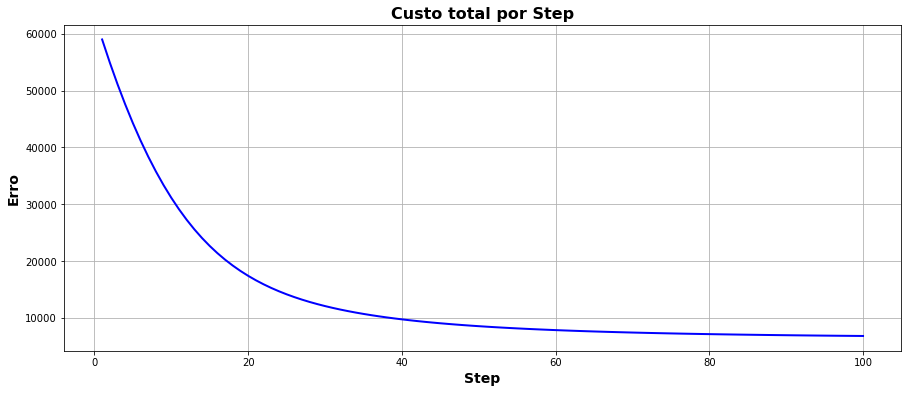

In [37]:
model.print_MSE_steps()

- Mas ao variar linhas a similaridade varia bastante
- Uma possibilidade seria estimar melhores parametros
- Analisando pelo RMSE a medida que aumento o step, há uma queda no erro medio quadratico

- Vou criar uma função que tera varias listas com varios parametros, e inicialmente realizar um loop aninhado:
    - estimando os melhores parametros e observando a curva do erro em um gráfico
    - vou inicializar uma lista vazia e ir adicionando a media dos mse, e depois observar quel teve o menor erro
    
** __observação:
    - A fim de problemas de processamento do computador, não vou estimar parametros muito complexos.__

In [38]:
# Estimando valores
K = [2,3]
steps = [300,500]
alpha = [ 0.01]
beta = [0.1]

Fatoração concluída. Tempo aproximado: 1 minuto(s).
Parametros
k:  2
steps:  300
alpha:  0.01
beta:  0.1


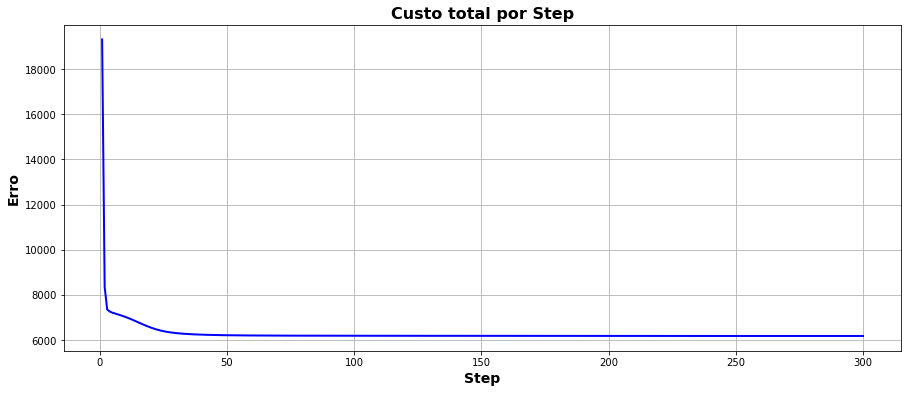

mse_mean:  6293.539211979236
******************************
Fatoração concluída. Tempo aproximado: 2 minuto(s).
Parametros
k:  2
steps:  500
alpha:  0.01
beta:  0.1


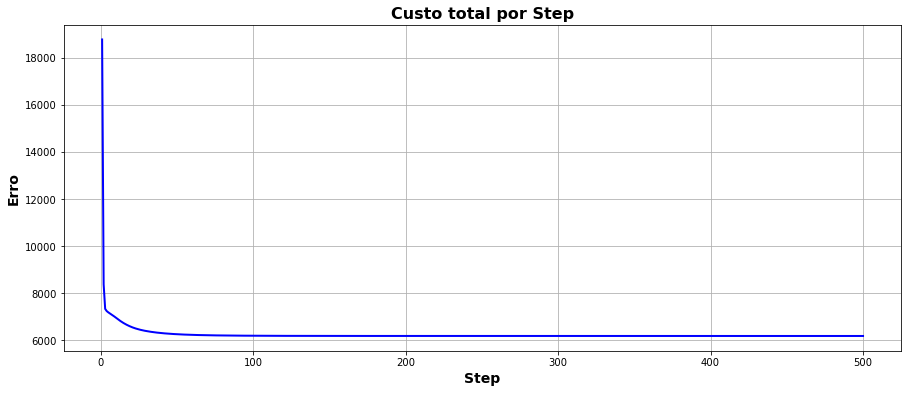

mse_mean:  6255.189658389724
******************************
Fatoração concluída. Tempo aproximado: 2 minuto(s).
Parametros
k:  3
steps:  300
alpha:  0.01
beta:  0.1


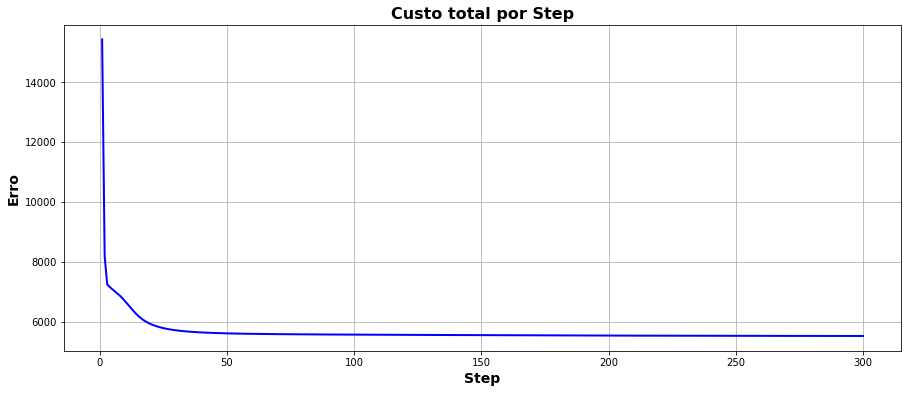

mse_mean:  5663.562161995455
******************************
Fatoração concluída. Tempo aproximado: 2 minuto(s).
Parametros
k:  3
steps:  500
alpha:  0.01
beta:  0.1


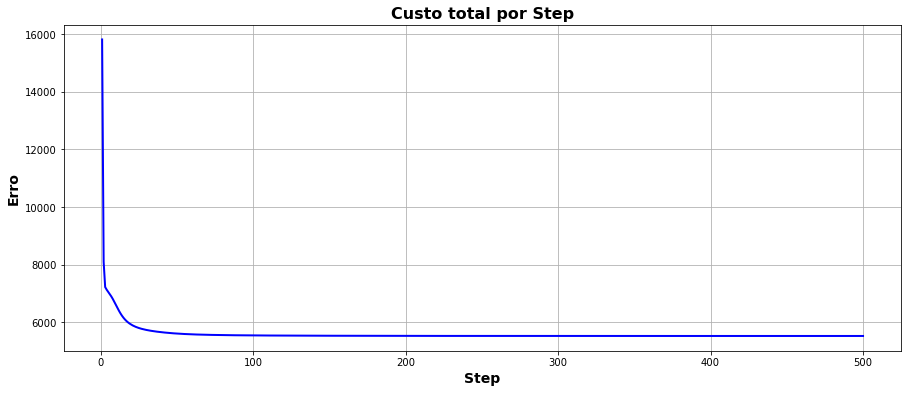

mse_mean:  5595.927669598354
******************************
Menor Mse:  5595.927669598354
******************************


In [41]:
lista_best_params = [] # lista com erros, iniciando vazia
for a in K: 
    for b in steps:
        for c in alpha:
            for d in beta:
                model_1 = MatrixFactorization(dataframe = pd.DataFrame(train, columns = R.columns, index = R.index), 
                              K = a, steps = b, alpha = c, beta = d)
                model_1.fit()
                df = pd.DataFrame(model_1.predict(), columns = R.columns, index = R.index).round(2)
                print("Parametros")
                print("k: ", a)
                print("steps: ", b)
                print("alpha: ",c)
                print("beta: ",d)
                model_1.print_MSE_steps() 
                lista_mse = model_1.mse()
                soma = sum(lista_mse)
                print("mse_mean: ", soma/ len(lista_mse))
                print("*"*30)

                erros = soma/ len(lista_mse)
                lista_best_params.append(erros)
                
lista_best_params.sort()
print('Menor Mse: ', lista_best_params[0])
print("*"*30)

#### Ao gerar um loop em alguns modelos alterando os parametros, cheguei na conclusão que o modelo com k=3, 500 steps, alpha 0.01 e beta 0.1 foi o modelo que teve a melhor nota.
- Próximo passo e ver como esse modelo performa nos dados de validação.

In [42]:
best_model = MatrixFactorization(dataframe = pd.DataFrame(train, columns = R.columns, index = R.index), 
                          K = 3, steps = 500, alpha = 0.01, beta = 0.1)

In [43]:
best_model.fit()

Fatoração concluída. Tempo aproximado: 2 minuto(s).


In [47]:
df_treino = pd.DataFrame(best_model.predict(), columns = R.columns, index = R.index).round(2)

In [63]:
df_treino.head()

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,...,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,3.76,3.25,2.62,3.71,3.23,3.67,4.15,4.28,4.40,4.55,...,3.83,3.20,3.02,2.15,3.78,3.61,3.15,1.72,4.17,2.60
User_1,3.26,2.90,3.86,3.58,2.59,2.23,4.22,3.57,3.62,3.12,...,3.22,2.98,2.87,3.04,1.58,3.59,2.65,1.84,3.54,2.73
User_2,3.14,2.66,1.32,2.92,2.80,3.59,3.17,3.70,3.87,4.36,...,3.26,2.56,2.36,1.06,4.14,2.79,2.66,1.21,3.53,1.92
User_3,4.28,3.83,4.45,4.40,3.56,3.27,5.03,4.50,4.31,3.73,...,4.26,3.85,3.84,4.15,2.45,4.40,3.63,2.48,4.59,3.36
User_4,4.14,3.69,3.37,3.94,3.62,3.72,4.33,4.29,3.95,3.64,...,4.18,3.62,3.70,3.75,3.20,3.90,3.64,2.33,4.44,2.95


#### Testando nos dados de validação

In [64]:
best_model_val = MatrixFactorization(dataframe = pd.DataFrame(val, columns = R.columns, index = R.index), 
                          K = 3, steps = 500, alpha = 0.01, beta = 0.1)

In [65]:
best_model_val.fit()

Fatoração concluída. Tempo aproximado: 1 minuto(s).


In [68]:
df_val = pd.DataFrame(best_model_val.predict(), columns = R.columns, index = R.index).round(2)
df_val.head()

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,...,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,4.90,2.08,4.24,2.31,3.95,1.40,4.26,3.40,2.11,4.30,...,2.09,1.57,4.02,2.10,2.24,3.73,2.92,1.76,3.45,3.37
User_1,3.88,1.20,3.62,1.20,2.72,1.02,2.94,2.26,0.86,3.69,...,1.25,0.44,3.33,1.60,1.20,2.29,2.73,0.90,2.59,2.43
User_2,2.68,2.67,1.97,2.67,1.90,1.16,3.16,3.01,3.03,2.80,...,2.72,2.12,2.48,1.10,2.26,3.13,2.01,2.37,2.95,2.51
User_3,4.21,3.77,3.05,3.98,3.44,1.69,4.88,4.49,4.45,3.95,...,3.78,3.32,3.64,1.80,3.48,4.89,2.61,3.40,4.21,3.79
User_4,3.92,2.53,3.32,2.46,2.61,1.37,3.71,3.30,2.54,4.04,...,2.62,1.61,3.56,1.59,2.16,3.31,3.02,2.14,3.51,3.03


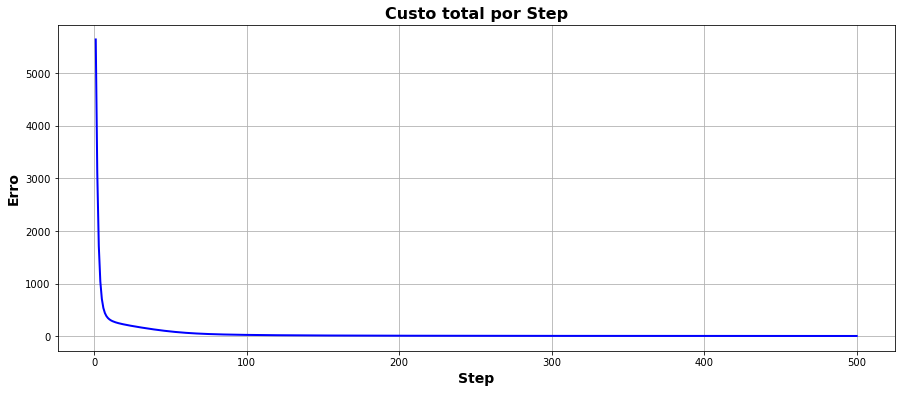

mse_mean:  54.71450206306839
******************************


In [72]:
best_model_val.print_MSE_steps()
lista_mse = best_model_val.mse()
soma = sum(lista_mse)
print("mse_mean: ", soma/ len(lista_mse))
print("*"*30)

- Modelo teve boa performance nos dados de validação
- Mas será que as similaridades entre os usuarios se mantém?
- E será que alguma metodologia, pode constatar que o modelo está tendo um bom resultado?

Média Treino:  3.6970027247956376


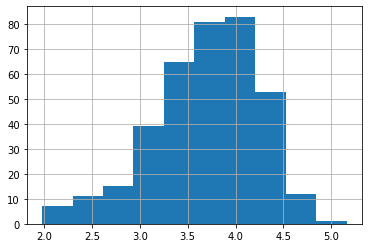

In [83]:
# Observando a coluna do filme 1, a média foi similar no contexto geral

df_treino['Filme_1'].hist()
print("Média Treino: ",df_treino['Filme_1'].mean())

Média Treino:  3.3447956403269754


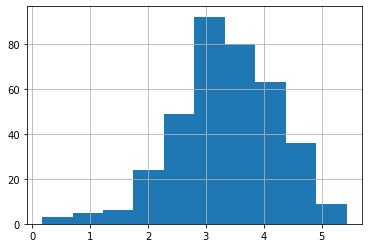

In [82]:
df_val['Filme_1'].hist()
print("Média Treino: ",df_val['Filme_1'].mean())

- A fim de investigar se o preenchimento das variaveis teve ou não um bom comportamento, vou realizar as seguintes etapas:
    - Gerar um loop e pegar a media de cada coluna
    - Criar uma lista e transformar em uma serie e plotar um gráfico de linha, o comportamento estastitico dos dfs(treino, validação)

In [103]:
lista_media_treino = []
for x in df_treino:
    lista_media_treino.append(df_treino[x].mean())

In [130]:
lista_media_val = []
for x in df_val:
    lista_media_val.append(df_val[x].mean())

In [131]:
media_treino = pd.Series(lista_media_treino)
media_val = pd.Series(lista_media_val)

In [132]:
treino_val = pd.DataFrame([media_treino, media_val])

               0          1
count  80.000000  80.000000
mean    3.294327   3.096510
std     0.565826   0.699811
min     1.360054   0.914905
25%     3.067302   2.828658
50%     3.351444   3.155858
75%     3.691219   3.571410
max     4.497738   4.439128


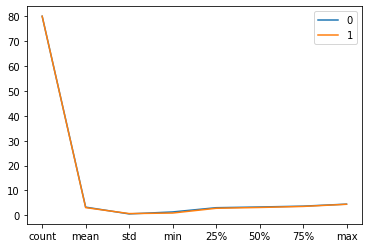

In [144]:
treino_val.T.describe().plot()
print(treino_val.T.describe())

### Gráficos com comportamentos bem similares

- Agora e ver nos dados de teste o comportamento dos dados de teste

#### Testando nos dados de teste

In [139]:
best_model_test = MatrixFactorization(dataframe = pd.DataFrame(val, columns = R.columns, index = R.index), 
                          K = 3, steps = 500, alpha = 0.01, beta = 0.1)

In [140]:
best_model_test.fit()

Fatoração concluída. Tempo aproximado: 1 minuto(s).


In [141]:
df_test = pd.DataFrame(best_model_test.predict(), columns = R.columns, index = R.index).round(2)
df_test.head()

,Filme_1,Filme_2,Filme_3,Filme_4,Filme_5,Filme_6,Filme_7,Filme_8,Filme_9,Filme_10,...,Filme_71,Filme_72,Filme_73,Filme_74,Filme_75,Filme_76,Filme_77,Filme_78,Filme_79,Filme_80
User_0,5.07,3.68,4.67,3.02,4.56,1.26,4.88,3.28,5.39,4.64,...,4.00,3.26,4.54,1.39,2.56,3.95,1.67,3.56,2.82,3.83
User_1,3.87,2.29,3.16,0.74,3.56,0.82,3.07,1.83,2.83,4.30,...,1.58,1.13,2.36,0.57,0.74,2.30,0.09,1.92,0.56,1.85
User_2,2.28,2.44,1.57,2.73,1.59,0.70,2.86,2.67,2.93,1.69,...,2.76,2.28,2.51,1.40,2.28,2.57,2.39,2.33,2.96,2.58
User_3,3.74,4.41,1.33,4.37,2.08,1.13,4.75,5.17,3.84,3.21,...,3.95,3.13,3.33,2.74,3.74,4.40,4.64,3.79,5.11,4.03
User_4,3.92,3.37,2.64,2.72,3.03,1.01,4.04,3.43,3.73,3.73,...,3.06,2.40,3.17,1.61,2.36,3.43,2.30,2.98,2.92,3.12


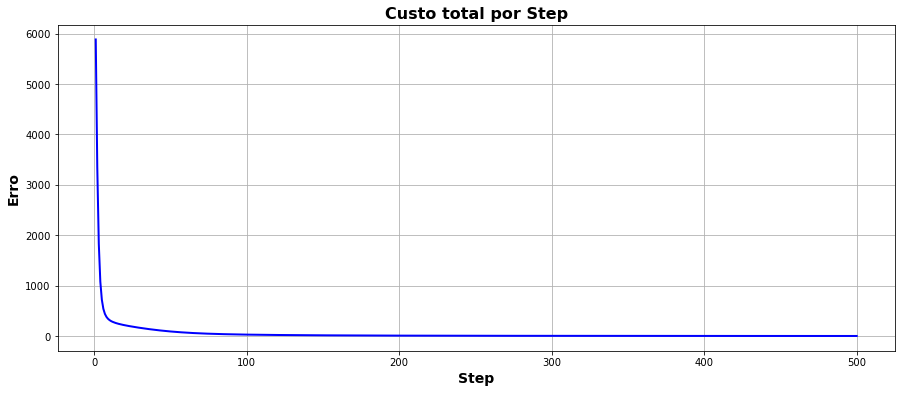

mse_mean:  57.57719129673892
******************************


In [142]:
best_model_test.print_MSE_steps()
lista_mse = best_model_test.mse()
soma = sum(lista_mse)
print("mse_mean: ", soma/ len(lista_mse))
print("*"*30)

#### O modelo teve um bom resultado!

- O modelo teve uma boa performance nas suposiçoes das possiveis notas dos usuarios, podemos comprovar isso pelas media, mediana
desvio padrão e quartis.
- No momento de estimar os parametros, é notável que ao aumentar o numero de k e de steps, a performance do modelo teve mudanças relevantes na análise.